In [ ]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

### Загрузка библиотек

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
from torchvision.transforms import InterpolationMode

In [ ]:
# наша библиотека
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [ ]:
# наша библиотека
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [10]:
from svetlanna.transforms import ToWavefront

In [ ]:
# выборка данных волновых фронтов
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import IlluminatedApertureDataset

In [12]:
from tqdm import tqdm

In [13]:
import json

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Оптическая нейронная сеть

В этом примере реализованы несколько экспериментов, основанных на оптической нейронной сети с архитектурой из этой [статьи](https://www.science.org/doi/10.1126/science.aat8084).

# 0. Экспериментальные параметры

In [ ]:
working_frequency = 0.4 * 1e12 # [Гц]
C_CONST = 299_792_458  # [м / с]

In [17]:
EXP_NUMBER = 1

In [ ]:
EXP_CONDITIONS = {
    # параметры симуляции
    'wavelength'  : C_CONST / working_frequency,  # [м]
    'layer_size_m': 8 * 1e-2 / 2 * 3,  # [m] - размеры по x и y равны!
    'layer_nodes' : int(100 / 2 * 3),  # 100,
    # TOOLS
    'tensorboard' : True,  # для использования тензорборда!
    # DATASET
    'digit_resize' : 17,  # актуальный размер цифры в пикселях
    'ds_apertures': True,  # Если набор данных создан с использованием апертур в форме цифры (True) или с использованием прямой модуляции (False)
# необходимо указать, если 'ds_apertures' == False, значения: 'amp', 'phase' или 'both'
    'ds_modulation': None,
        # должен быть указан если'ds_apertures' == True
    'gauss_waist_radius': 2e-2,  # [м] - радиус перетяжки пучка Гаусса
    'distance_to_aperture': 3e-2,  # [м]
    # SETUP
    'propagator': 'AS',  # метод распространения для FreeSpase: 'AS' или 'fresnel' (так же нужен для выборки данных с апертурами)
        # дифракционные слои
    'n_diff_layers': 5,  # количество дифракционных слоев
    'diff_layer_max_phase': torch.pi,  # максимальный фазовый набег для каждого DiffractiveLayer
    'diff_layer_mask_init': 'const',  # инициализация масок DiffractiveLayer : 'const' или 'random'
    'diff_layers_seeds': 123,  # if 'random': seed to generate seeds to init all masks!
        # free space
    'layers_distance': 3e-2,  # [m], расстояние между слоями
        # апертуры
    'add_apertures': True,  # если True - добавляет квадратные апертуры (посередине) перед каждым дифракционным слоем
    'apertures_size': (50, 50),  # размер дополнительных отверстий в установке
        # детектор
    'detector_zones': 'segments',  # форма зон детектора: «квадраты» или «круги» или «полосы»
    'detector_transpose': False,  # транспонирование детектора (делает «полосы» горизонтальными вместо вертикальных)
    # процесс обучения
    'train_bs': 8,
    'val_bs': 20,  # размер батчча для валидации
    'train_split_seed': 178,  # seed для разделения выборки данных
    'epochs': 10,
}

In [19]:
# import SummaryWriter from tensorboard

if 'tensorboard' in EXP_CONDITIONS.keys():
    if EXP_CONDITIONS['tensorboard']:

        from torch.utils.tensorboard import SummaryWriter


In [20]:
today_date = datetime.today().strftime('%d-%m-%Y')

RESULTS_FOLDER = (
    f'models/03_mnist_experiments/{today_date}_experiment_{EXP_NUMBER:02d}'
)

RESULTS_FOLDER

'models/03_mnist_experiments/13-12-2024_experiment_01'

In [21]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [ ]:
# сохраняем условия эксперимента
json.dump(EXP_CONDITIONS, open(f'{RESULTS_FOLDER}/conditions.json', 'w'))

In [23]:
# OR read conditions from file:
# EXP_CONDITIONS = json.load(open(f'{RESULTS_FOLDER}/conditions.json))
# print(EXP_CONDITIONS)

# 1. Параметры симуляции

In [ ]:
working_wavelength = EXP_CONDITIONS['wavelength']  # [м]
print(f'длина волны = {working_wavelength * 1e6:.3f} нм')

lambda = 749.481 um


In [ ]:
# физические размеры слоев(из статьи)
x_layer_size_m = EXP_CONDITIONS['layer_size_m']  # [m]
y_layer_size_m = x_layer_size_m

In [ ]:
# количество нейронов в симуляции
x_layer_nodes = EXP_CONDITIONS['layer_nodes']
y_layer_nodes = x_layer_nodes

In [ ]:
print(f'Размер слоя в нейронах: {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (neurons): 150 x 150 = 22500


In [ ]:
neuron_size = x_layer_size_m / x_layer_nodes
print(f'Размер нейрона = {neuron_size * 1e6:.3f} um')

Neuron size = 800.000 um


In [ ]:


SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Подготовка выборки данных (Инженер данных)

## 2.1. [Выборка данных MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset): загрузка и преобразование в волновые фронты

In [ ]:
# инициализируем директорию для набора данных
MNIST_DATA_FOLDER = './data'  # директория для хранения данных

### 2.1.1. Загрузка тренировочной и тестовой выборок изображений

In [ ]:
# тренировочная выборка MNIST
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # для тренировочной выборки
    download=False,
)

In [ ]:
# тестовая выборка MNIST
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # для тествовой выборки
    download=False,
)

In [ ]:
print(f'Размер тренировочной выборки: {len(mnist_train_ds)}')
print(f'Размер тестовой выборки: {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Создание тренировочной и тестовой выборок волновых фронтов

In [ ]:
DS_WITH_APERTURES = EXP_CONDITIONS['ds_apertures']
# if True будем использовать IlluminatedApertureDataset для создания выборок волновых фронтов
# else - DatasetOfWavefronts
DS_WITH_APERTURES

True

In [ ]:
# выбор типа модуляции DatasetOfWavefronts if DS_WITH_APERTURES == False
MODULATION_TYPE = EXP_CONDITIONS['ds_modulation']  # 'phase', 'amp', 'amp&phase'

# выбор метода и дистанции для FreeSpace в IlluminatedApertureDataset
DS_METHOD = EXP_CONDITIONS['propagator']
DS_DISTANCE = EXP_CONDITIONS['distance_to_aperture']  # [м]

DS_BEAM = Wavefront.gaussian_beam(
    simulation_parameters=SIM_PARAMS,
    waist_radius=EXP_CONDITIONS['gauss_waist_radius'],  # [м]
)

In [ ]:
# изменяем размер изображения, чтобы он совпадал с SimulationParameters
resize_y = EXP_CONDITIONS['digit_resize']
resize_x = resize_y  # shape for transforms.Resize

pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [ ]:
# составляем все преобразования для DatasetOfWavefronts
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отступ
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- выбор типа модуляции!!!
  ]
)

# составляем все преобразования для IlluminatedApertureDataset
image_to_aperture = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отступ
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),  # padding to match sizes!
  ]
)

In [ ]:
# Тренировочный набор данных волновых фронтов
if not DS_WITH_APERTURES:
    mnist_wf_train_ds = DatasetOfWavefronts(
        init_ds=mnist_train_ds,  # выборка изображений
        transformations=image_transform_for_ds,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
    )
else:
    mnist_wf_train_ds = IlluminatedApertureDataset(
        init_ds=mnist_train_ds,  # выборка изображений
        transformations=image_to_aperture,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

In [ ]:
# Тестовый набор данных волновых фронтов
if not DS_WITH_APERTURES:
    mnist_wf_test_ds = DatasetOfWavefronts(
        init_ds=mnist_test_ds,  # выборка изображений
        transformations=image_transform_for_ds,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
    )
else:
    mnist_wf_test_ds = IlluminatedApertureDataset(
        init_ds=mnist_test_ds,  # выборка изображений
        transformations=image_to_aperture,  # преобразование изображений
        sim_params=SIM_PARAMS,  # параметры симуляции
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

In [ ]:
print(f'Размер тренировочной выборки: {len(mnist_wf_train_ds)}')
print(f'Размер тестовой выборки: {len(mnist_wf_test_ds)}')

Train data: 60000
Test data : 10000


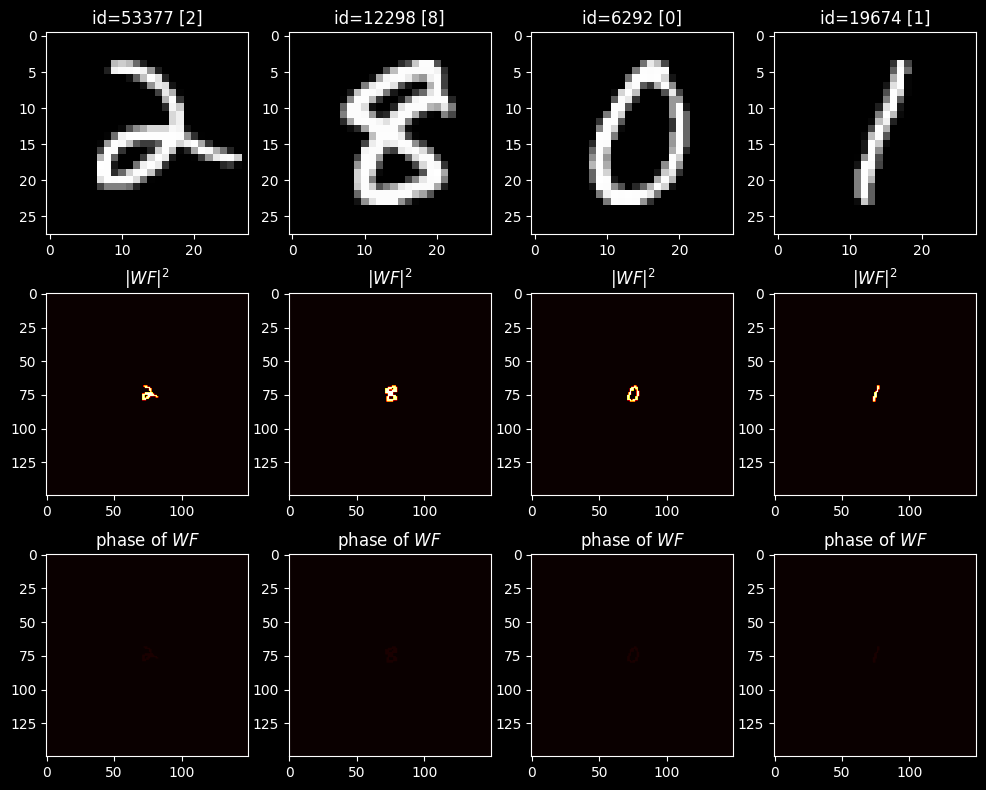

In [ ]:
# строим несколько примеров из тренировочного набора данных
n_examples= 4  # количество примеров
# индексы изображений
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []
cmap = 'hot'

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]

    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity[0], cmap=cmap,
        vmin=0, vmax=1
    )

    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase[0], cmap=cmap,
        vmin=0, vmax= 2 * torch.pi
    )

plt.show()

# 3. Оптическая сеть

In [ ]:
NUM_OF_DIFF_LAYERS = EXP_CONDITIONS['n_diff_layers']  # количество дифракционных слоев
FREE_SPACE_DISTANCE = EXP_CONDITIONS['layers_distance']  # [м]

## 3.1. Архитектура

### 3.1.1. Список элементов

> Для помощи в создании 3d-печати и конструкции $D^2NN$, использована функция сигмоиды для ограничения значения фазового набега каждого нейрона до $0-2π$ и $0-π$, для сетей визуализации и классификаторов соответственно.

In [43]:
MAX_PHASE = EXP_CONDITIONS['diff_layer_max_phase']

In [44]:
from src.for_setup import get_const_free_space, get_random_diffractive_layer
from torch.nn import functional

Функция для создания списка элементов:

In [ ]:
# добавим апертуры перед каждым дифракционным слоем
ADD_APERTURES = EXP_CONDITIONS['add_apertures']
APERTURE_SZ = EXP_CONDITIONS['apertures_size']

In [ ]:
def get_elements_list(
    num_layers,
    simulation_parameters: SimulationParameters,
    freespace_method,
    masks_seeds,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Composes a list of elements for setup.
        Optical system: FS|DL|FS|...|FS|DL|FS|Detector
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    masks_seeds : torch.Tensor()
        Torch tensor of random seeds to generate masks for diffractive layers.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # список элементов

    if apertures:  # эквивалентные маски для всех апертур (выбираем часть в середине)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad

        # преобразование отступов для соответствия размерам параметров симуляции
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # собираем архитектуру
    for ind_layer in range(num_layers):
        if ind_layer == 0:
            # первый FreeSpace перед первым DiffractiveLayer
            elements_list.append(
                get_const_free_space(
                    simulation_parameters,
                    FREE_SPACE_DISTANCE,  # в [м]
                    freespace_method=freespace_method,
                )
            )

        # добавляем апертуры перед каждым дифракционным слоем
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=nn.Parameter(aperture_mask, requires_grad=False)
                )
            )

        # добавляем DiffractiveLayer
        elements_list.append(
            get_random_diffractive_layer(
                simulation_parameters,
                mask_seed=masks_seeds[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # добавляем FreeSpace
        elements_list.append(
            get_const_free_space(
                simulation_parameters,
                FREE_SPACE_DISTANCE,  # в [м]
                freespace_method=freespace_method,
            )
        )

    # добавляем детектор в конце системы
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # детектор возвращает интенсивность волнового фронта
        )
    )

    return elements_list

Постоянные для инициализации системы:

In [ ]:
FREESPACE_METHOD = EXP_CONDITIONS['propagator'] # TODO: 'AS' returns nan's?

if EXP_CONDITIONS['diff_layer_mask_init'] == 'random':
    MASKS_SEEDS = torch.randint(
        low=0, high=100,
        size=(NUM_OF_DIFF_LAYERS,),
        generator=torch.Generator().manual_seed(EXP_CONDITIONS['diff_layers_seeds'])
        # для генерации таких же начальных масок
    )  # для такой же случайной генерации

if EXP_CONDITIONS['diff_layer_mask_init'] == 'const':
    MASKS_SEEDS = torch.ones(size=(NUM_OF_DIFF_LAYERS,)) * torch.pi / 2  # константа для инициализации масок

MASKS_SEEDS

tensor([1.5708, 1.5708, 1.5708, 1.5708, 1.5708])

### 3.1.2. Составляем `LinearOpticalSetup`

In [ ]:
def get_setup(
    simulation_parameters,
    num_layers,
    apertures=False,
    aperture_size=(100,100)
):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers,
        simulation_parameters,
        FREESPACE_METHOD,
        MASKS_SEEDS,
        apertures=apertures,
        aperture_size=aperture_size
    )  # пересоздаем список элементов

    return LinearOpticalSetup(elements=elements_list)

In [ ]:
lin_optical_setup = get_setup(
    SIM_PARAMS,
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)
# Комментарий: Lin - фамилия первого автора статьи

In [50]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): Aperture()
  (2): DiffractiveLayer()
  (3): FreeSpace()
  (4): Aperture()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): Aperture()
  (8): DiffractiveLayer()
  (9): FreeSpace()
  (10): Aperture()
  (11): DiffractiveLayer()
  (12): FreeSpace()
  (13): Aperture()
  (14): DiffractiveLayer()
  (15): FreeSpace()
  (16): Detector()
)

#### Пример распространения волновых фронтов

In [51]:
example_wf = mnist_wf_train_ds[128][0]

In [52]:
mnist_wf_train_ds[128][1]

1

In [53]:
setup_scheme, wavefronts = lin_optical_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Detector] -(17)->


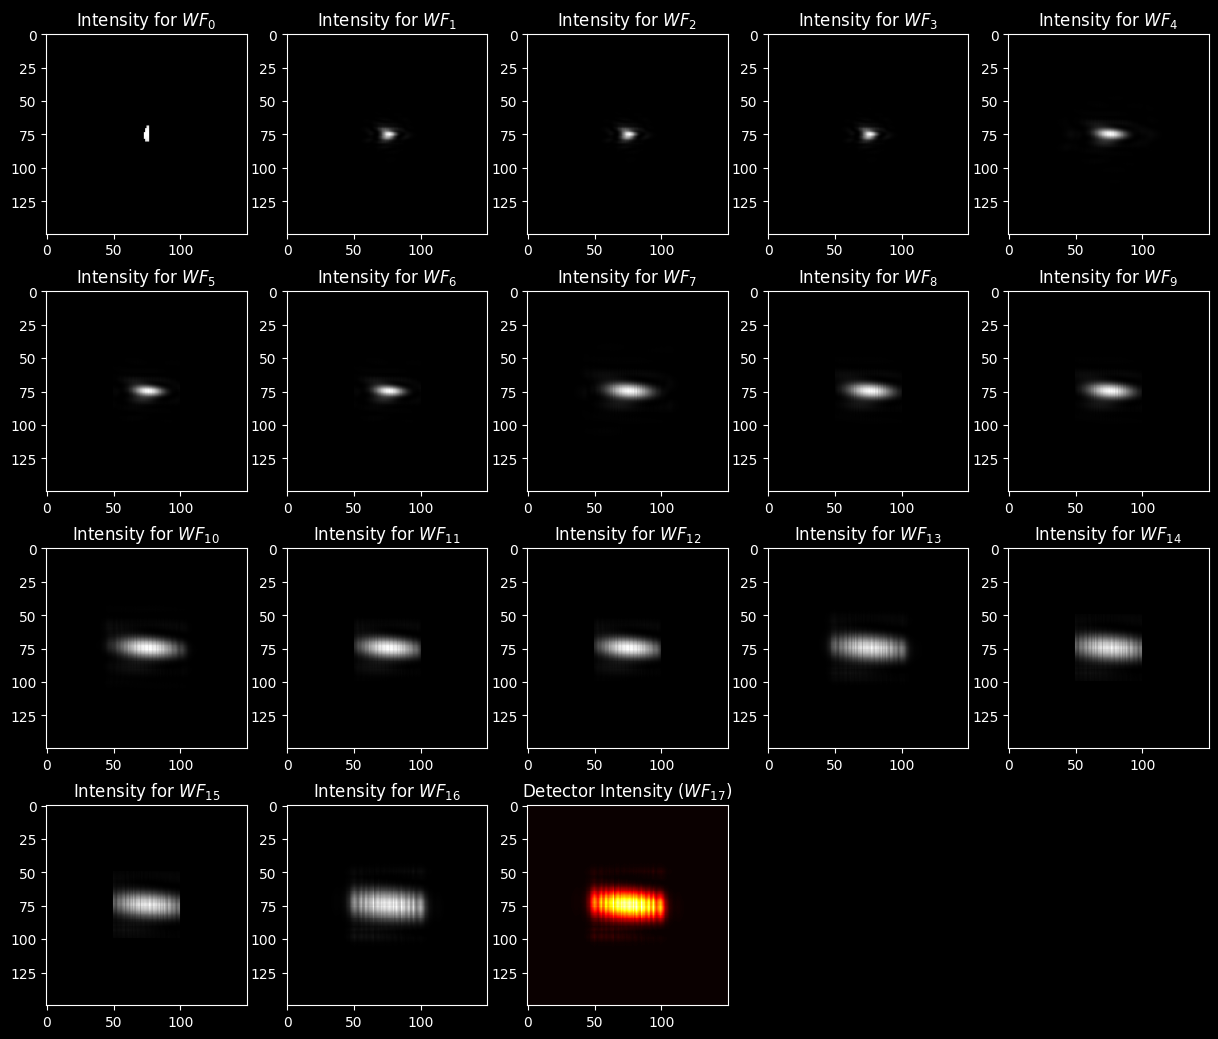

In [ ]:
print(setup_scheme)  # выводим оптическую систему

n_cols = 5  # количество колонок для отображения всех волновых фронтов при распространении
n_rows = (len(lin_optical_setup.net) // n_cols) + 1

to_plot = 'amp'  # <--- выбираем, что будем отображать: 'amp' - амплитуду, 'phase' - фазу
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# создаем фигуру для отображения волновых фронтов
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# выключаем лишние оси
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# строим волновые фронты
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # строим фазу для каждого волнового фронта, потому что картинки интенсивности неотличимы друг от друга
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Фаза для $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Фаза детектора($WF_{' + f'{ind_wf}' + '})$')
            # у детектора нет фазы!

    if to_plot == 'amp':
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # выход детектора (не wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )

    # Комментарий: выход детектора - тензор! У него нет методов Wavefront (например .phase or .intensity)!

plt.show()

### 3.1.3 Обработчик детектора

In [55]:
number_of_classes = 10

In [56]:
import src.detector_segmentation as detector_segmentation
# Functions to segment detector: squares_mnist, circles, angular_segments

In [57]:
if ADD_APERTURES or APERTURE_SZ:
    y_detector_nodes, x_detector_nodes = APERTURE_SZ
else:
    y_detector_nodes, x_detector_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))

In [58]:
ADD_APERTURES

True

#### Маска детектора (квадратные зоны)

In [ ]:
detector_squares_mask = detector_segmentation.squares_mnist(
    y_detector_nodes, x_detector_nodes,  # размер детектора или апертуры (в середине детектора)
    SIM_PARAMS
)

#### Маска детектора (круглые зоны)

In [ ]:
detector_circles_mask = detector_segmentation.circles(
    y_detector_nodes, x_detector_nodes,  # размер детектора или апертуры (в середине детектора)
    number_of_classes,
    SIM_PARAMS
)

#### маска детектора (зоны - угловые сегменты)

In [ ]:
detector_angles_mask = detector_segmentation.angular_segments(
    y_detector_nodes, x_detector_nodes,  # размер детектора или апертуры (в середине детектора)
    number_of_classes,
    SIM_PARAMS
)

#### Обработчик детектора

In [62]:
CIRCLES_ZONES = EXP_CONDITIONS['detector_zones'] == 'circles'
CIRCLES_ZONES

False

In [63]:
if EXP_CONDITIONS['detector_zones'] == 'circles':
    selected_mask = detector_circles_mask
    print('circles selected!')

if EXP_CONDITIONS['detector_zones'] == 'squares':
    selected_mask = detector_squares_mask
    print('squares selected!')

if EXP_CONDITIONS['detector_zones'] == 'segments':
    selected_mask = detector_angles_mask
    print('angular segments selected!')

if EXP_CONDITIONS['detector_zones'] == 'strips':
    selected_mask = None
    print('strips selected!')

angular segments selected!


In [ ]:
detector_processor = DetectorProcessorClf(
    num_classes=number_of_classes,
    simulation_parameters=SIM_PARAMS,
    segmented_detector=selected_mask,  # выбираем маску!
    segments_zone_size=APERTURE_SZ
)

In [65]:
if 'detector_transpose' in EXP_CONDITIONS.keys():
    if EXP_CONDITIONS['detector_transpose']:
        detector_processor.segmented_detector = detector_processor.segmented_detector.T

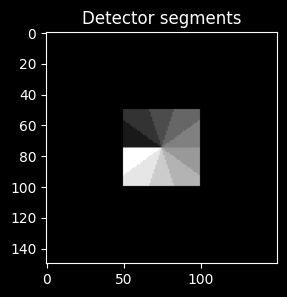

In [66]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_processor.segmented_detector, cmap='grey')

plt.show()

#### Визуализация зон детектора

In [67]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = detector_processor.segmented_detector.clone().detach()

In [ ]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    if EXP_CONDITIONS['detector_zones'] == 'circles':
        for ind_class in range(number_of_classes):
            # use `circles_radiuses`, `x_layer_size_m`, `x_layer_nodes`
            rad_this = (circles_radiuses[ind_class] / x_layer_size_m * x_layer_nodes)

            zone_circ = patches.Circle(
                (x_layer_nodes / 2, y_layer_nodes / 2),
                rad_this,
                linewidth=ZONES_LW,
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )

            zones_patches.append(zone_circ)
    else:
        if EXP_CONDITIONS['detector_zones'] == 'segments':
            class_segment_angle = 2 * torch.pi / number_of_classes
            len_lines_nodes = int(x_layer_nodes / 2)

            delta = 0.5
            idx_y, idx_x = (detector_mask > -1).nonzero(as_tuple=True)
            zone_rect = patches.Rectangle(
                (idx_x[0] - delta, idx_y[0] - delta),
                idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
                linewidth=ZONES_LW,
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )
            zones_patches.append(zone_rect)

            ang = torch.pi
            x_center, y_center = int(x_layer_nodes / 2), int(y_layer_nodes / 2)
            for ind_class in range(number_of_classes):
                path_line = Path(
                    [
                        (x_center, y_center),
                        (
                            x_center + len_lines_nodes * np.cos(ang),
                            y_center + len_lines_nodes * np.sin(ang)
                        ),
                    ],
                    [
                        Path.MOVETO,
                        Path.LINETO
                    ]
                )
                bound_line = patches.PathPatch(
                    path_line,
                    facecolor='none',
                    lw=ZONES_LW,
                    edgecolor=ZONES_HIGHLIGHT_COLOR,
                )

                zones_patches.append(bound_line)

                ang += class_segment_angle
        else:
            delta = 0.5

            for ind_class in range(number_of_classes):
                idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)

                zone_rect = patches.Rectangle(
                    (idx_x[0] - delta, idx_y[0] - delta),
                    idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
                    linewidth=ZONES_LW,
                    edgecolor=ZONES_HIGHLIGHT_COLOR,
                    facecolor='none'
                )

                zones_patches.append(zone_rect)

    return zones_patches

# 4. Тренировка сети

Объекты в данный момент:
- `lin_optical_setup` : `LinearOpticalSetup` – линейная оптическая нейронная сеть состоящая из Elements
- `detector_processor` : `DetectorProcessorClf` – этот слой обрабатывает изображение с детектора и рассчитывает вероятности принадлежности к классам.

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# if DEVICE == torch.device('cpu'):
#     DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

DEVICE

device(type='cpu')

## 4.1. Некоторые обязательные действия

### 4.1.1. `DataLoader`'s

In [ ]:
train_bs = EXP_CONDITIONS['train_bs']  # размер батча для обучения
val_bs = EXP_CONDITIONS['val_bs']

> Для этой задачи были разработаны маски пропускания фазы путем обучения пятислойной нейронной сети $D^2$ с $55000$ изображениями ($5000$ проверочными изображениями) из базы данных рукописных цифр MNIST (Модифицированный Национальный институт стандартов и технологий).

In [ ]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # размер из статьи
    generator=torch.Generator().manual_seed(EXP_CONDITIONS['train_split_seed'])  # для воспроизводимости
)

In [72]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Оптимизатор и функция потерь

Информация из [приложения](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) для классификации MNIST:

> Мы использовали алгоритм стохастического градиентного спуска Adam для обратного распространения ошибок и обновления
слоев сети для минимизации функции потерь.

In [ ]:
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # параметры сети!
)

In [74]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Циклы обучения и оценки

In [75]:
from src.clf_loops import onn_train_clf, onn_validate_clf

## 4.2. Тренировка оптической нейронной сети

### 4.2.1. Перед тренировкой

#### Маски дифракционных слоев

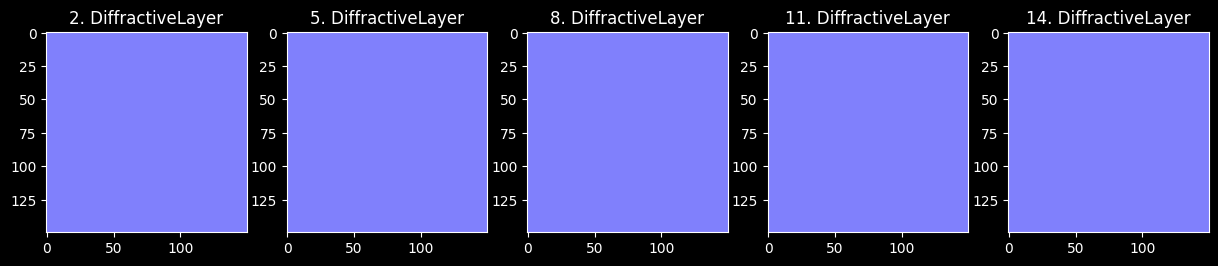

In [ ]:
n_cols = NUM_OF_DIFF_LAYERS  # количество колонок для отображения масок дифракционных слоев
n_rows = 1

lin_architecture_elements_list = get_elements_list(
    NUM_OF_DIFF_LAYERS,
    SIM_PARAMS,
    FREESPACE_METHOD,
    MASKS_SEEDS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)

cmap = 'gist_stern'

# строим фазы волновых фронтов
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

for ind_layer, layer in enumerate(lin_architecture_elements_list):
    if isinstance(layer, elements.DiffractiveLayer):  # строим маски
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        im = ax_this.imshow(
            layer.mask.detach().numpy(), cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )

        ind_diff_layer += 1

plt.show()

#### Метрики для выборки данных

In [ ]:
lin_optical_setup = get_setup(
    SIM_PARAMS.to(DEVICE),
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)

In [ ]:
lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

SIM_PARAMS = SIM_PARAMS.to(DEVICE)  # важно!
detector_processor = detector_processor.to(DEVICE)

In [79]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [ ]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    lin_optical_setup.net,  # оптическая сеть созданная в 3.
    test_wf_loader,  # загрузчик тестовой выборки
    detector_processor,  # обработчик детектора
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # оценка модели

print(
    'Результаты перед обучением на тестовой выборке:\n' +
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tТочность: {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.14it/s]

Results before training on TEST set:
	CE loss : 2.304648
	Accuracy : 9.7 %


### 4.2.2. Обучение

In [ ]:
n_epochs = EXP_CONDITIONS['epochs']
print_each = 1  # выводим каждую n-ю эпоху

In [ ]:
scheduler = None  #

In [ ]:
# пересоздаем систему для перезапуска обучения!

lin_optical_setup = get_setup(
    SIM_PARAMS.to(DEVICE),
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)

# Оптимизатор Linc для воссозданной сети!
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # параметры сети!
)

In [114]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): Aperture()
  (2): DiffractiveLayer()
  (3): FreeSpace()
  (4): Aperture()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): Aperture()
  (8): DiffractiveLayer()
  (9): FreeSpace()
  (10): Aperture()
  (11): DiffractiveLayer()
  (12): FreeSpace()
  (13): Aperture()
  (14): DiffractiveLayer()
  (15): FreeSpace()
  (16): Detector()
)

In [ ]:
lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

SIM_PARAMS = SIM_PARAMS.to(DEVICE)  # важно!
detector_processor = detector_processor.to(DEVICE)  # обработчик детектора должен быть на том же устройстве!

In [116]:
# tensorboard writer
if EXP_CONDITIONS['tensorboard']:
    # TODO: A custom name for a run?
    tensorboard_writer = SummaryWriter()
    print('Tensorboard writer created!')

Tensorboard writer created!


In [ ]:
train_epochs_losses = []
val_epochs_losses = []  # для хранения потерь

train_epochs_acc = []
val_epochs_acc = []  # для хранения точности

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # стартовое время (train)
    train_losses, _, train_accuracy = onn_train_clf(
        lin_optical_setup.net,  # оптическая сеть созданная в 3.
        train_wf_loader,  # загрузчик тренировочной выборки
        detector_processor,  # обработчик детектора
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # обучение модели
    mean_train_loss = np.mean(train_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # информация об обучении
        print('Результаты обучения')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tТочность: {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # валидация
    start_val_time = time.time()  # стартовое время (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        lin_optical_setup.net,  # оптическая сеть созданная в 3.
        val_wf_loader,  # загрузчик валидационной выборки
        detector_processor,  # обработчик детектора
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # оценка модели
    mean_val_loss = np.mean(val_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # validation info
        print('Результаты валидации')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tТочность: {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')

    if scheduler:
        scheduler.step(mean_val_loss)

    # ---------------------------------------------------- TENSORBOARD SECTION
    if EXP_CONDITIONS['tensorboard']:
        # отслеживание эксперимента через: tensorboard
        tensorboard_writer.add_scalars(
            main_tag="Loss",
            tag_scalar_dict={
                "train_loss": mean_train_loss,
                "val_loss": mean_val_loss,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
            },
            global_step=epoch
        )

        diff_layer_number = 1
        for layer in lin_optical_setup.net:
            # сохраняем маски для  Diffractive layers после каждой эпохи
            if isinstance(layer, elements.DiffractiveLayer):
                mask_np = layer.mask.detach().unsqueeze(0).numpy()

                # TODO: Figure to add?
                # fig_this, ax_this =  plt.subplots(1, 1, figsize=(5, 4))
                # im_this = ax_this.imshow(
                #     layer.mask.detach().numpy(), cmap=cmap,
                #     vmin=0, vmax=MAX_PHASE
                # )
                # cbar_this = fig.colorbar(im_this)
                # im_this.set_clim(0, MAX_PHASE)

                # WRITE
                tensorboard_writer.add_image(
                    f'DiffractiveLayer_{diff_layer_number}',
                    mask_np,
                    global_step=epoch
                )
                diff_layer_number += 1
        print(f'\t-> tensorboarded')
    # ---------------------------------------------------- TENSORBOARD SECTION

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:09<00:00, 22.18it/s]


Training results
	CE loss : 2.026149
	Accuracy : 69.7 %
	------------   309.92 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:16<00:00, 15.28it/s]


Validation results
	CE loss : 1.976295
	Accuracy : 76.0 %
	------------   16.36 s
	-> tensorboarded
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:25<00:00, 21.11it/s]


Training results
	CE loss : 1.954368
	Accuracy : 78.8 %
	------------   325.61 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.38it/s]


Validation results
	CE loss : 1.944904
	Accuracy : 78.9 %
	------------   17.38 s
	-> tensorboarded
Epoch #3: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:15<00:00, 21.78it/s]


Training results
	CE loss : 1.932177
	Accuracy : 80.4 %
	------------   315.66 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.83it/s]


Validation results
	CE loss : 1.927474
	Accuracy : 80.7 %
	------------   18.08 s
	-> tensorboarded
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:05<00:00, 18.79it/s]


Training results
	CE loss : 1.919771
	Accuracy : 81.1 %
	------------   365.97 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.67it/s]


Validation results
	CE loss : 1.918410
	Accuracy : 81.6 %
	------------   19.74 s
	-> tensorboarded
Epoch #5: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:09<00:00, 18.63it/s]


Training results
	CE loss : 1.911985
	Accuracy : 81.5 %
	------------   369.08 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.77it/s]


Validation results
	CE loss : 1.911945
	Accuracy : 81.1 %
	------------   21.25 s
	-> tensorboarded
Epoch #6: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:21<00:00, 18.02it/s]


Training results
	CE loss : 1.906370
	Accuracy : 81.9 %
	------------   381.45 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.72it/s]


Validation results
	CE loss : 1.906746
	Accuracy : 82.1 %
	------------   19.66 s
	-> tensorboarded
Epoch #7: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:52<00:00, 16.68it/s]


Training results
	CE loss : 1.902148
	Accuracy : 82.1 %
	------------   412.09 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.10it/s]


Validation results
	CE loss : 1.901731
	Accuracy : 81.5 %
	------------   20.67 s
	-> tensorboarded
Epoch #8: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:38<00:00, 17.25it/s]


Training results
	CE loss : 1.899022
	Accuracy : 82.0 %
	------------   398.52 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Validation results
	CE loss : 1.900397
	Accuracy : 80.5 %
	------------   19.51 s
	-> tensorboarded
Epoch #9: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [07:19<00:00, 15.64it/s]


Training results
	CE loss : 1.896814
	Accuracy : 82.2 %
	------------   439.46 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.49it/s]


Validation results
	CE loss : 1.898544
	Accuracy : 82.6 %
	------------   20.02 s
	-> tensorboarded
Epoch #10: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:51<00:00, 16.70it/s]


Training results
	CE loss : 1.894883
	Accuracy : 82.3 %
	------------   411.80 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.02it/s]

Validation results
	CE loss : 1.896155
	Accuracy : 81.4 %
	------------   17.83 s
	-> tensorboarded


In [120]:
if EXP_CONDITIONS['tensorboard']:
    tensorboard_writer.flush()
    tensorboard_writer.close()

In [ ]:
# run tensorboard
# !tensorboard --logdir=runs

### Кривые обучения

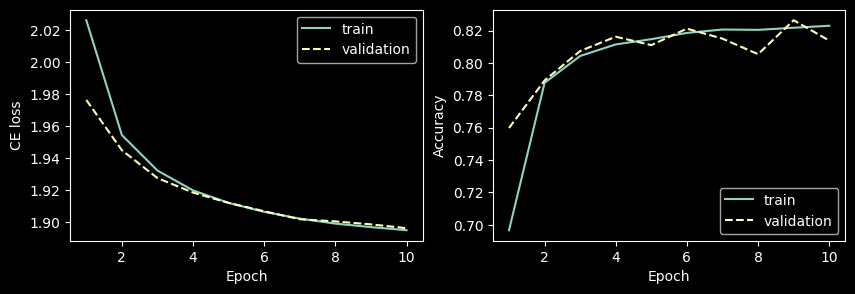

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), train_epochs_losses, label='обучение')
axs[0].plot(range(1, n_epochs + 1), val_epochs_losses, linestyle='dashed', label='валидация')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='обучение')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='валидация')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('эпоха')
axs[0].legend()

axs[1].set_ylabel('точность')
axs[1].set_xlabel('эпоха')
axs[1].legend()

plt.show()

In [122]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

### Сохранение

In [123]:
RESULTS_FOLDER

'models/03_mnist_experiments/13-12-2024_experiment_01'

In [124]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [ ]:
# путь для сохранения модели
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'
# путь для сохранения потерь
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

In [ ]:
# сохранение модели
torch.save(lin_optical_setup.net.state_dict(), model_filepath)

In [ ]:
# сохранение потерь
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

### 4.2.3. Обученные маски

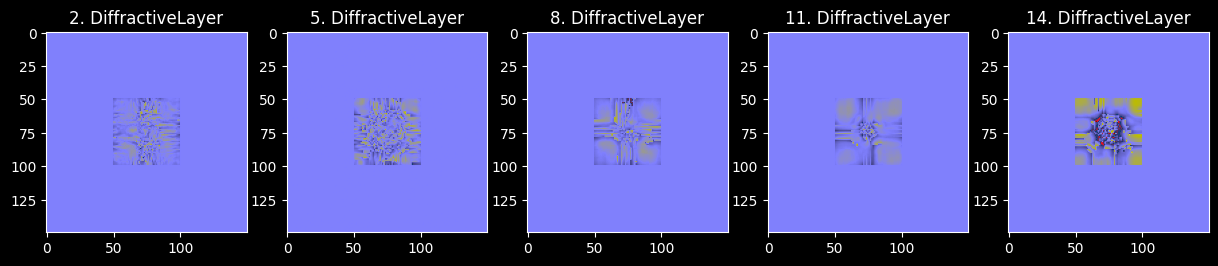

In [ ]:
n_cols = NUM_OF_DIFF_LAYERS  # количество колонок для визуализации масок DiffractiveLayer'
n_rows = 1

# строим фазы волновых фронтов
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'

for ind_layer, layer in enumerate(lin_optical_setup.net):
    if isinstance(layer, elements.DiffractiveLayer):  # строим маски дифракционных слоев
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        trained_mask = layer.mask.detach()

        # mask_seed = MASKS_SEEDS[ind_diff_layer].item()
        # random_mask = torch.rand(
        #     size=(sim_params.y_nodes, sim_params.x_nodes),
        #     generator=torch.Generator().manual_seed(mask_seed)
        # ) * (MAX_PHASE)

        ax_this.imshow(
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

plt.show()

### 4.2.4. Применение модели для неизвестных данных(тест)

In [ ]:
# список сохраненных моделей
dir_models = 'models/03_mnist_experiments'

filepathes = []

for file in os.listdir(dir_models):
    filename = os.fsdecode(file)
    if not filename.endswith(".pth"):
        filepathes.append(filename)

print(*sorted(filepathes), sep='\n')

.DS_Store
09-12-2024_experiment_01
13-12-2024_experiment_01
22-11-2024_experiment_01
22-11-2024_experiment_02
22-11-2024_experiment_03
27-11-2024_experiment_01


In [ ]:
# путь для сохранения модели
load_model_subfolder = f'13-12-2024_experiment_{EXP_NUMBER:02d}'
load_model_filepath = f'{dir_models}/{load_model_subfolder}/optical_setup_net.pth'

load_model_filepath

'models/03_mnist_experiments/13-12-2024_experiment_01/optical_setup_net.pth'

In [ ]:
# условия эксперимента
json.load(open(f'{RESULTS_FOLDER}/conditions.json'))

{'wavelength': 0.000749481145,
 'layer_size_m': 0.12,
 'layer_nodes': 150,
 'tensorboard': True,
 'digit_resize': 17,
 'ds_apertures': True,
 'ds_modulation': None,
 'gauss_waist_radius': 0.02,
 'distance_to_aperture': 0.03,
 'propagator': 'AS',
 'n_diff_layers': 5,
 'diff_layer_max_phase': 3.141592653589793,
 'diff_layer_mask_init': 'const',
 'diff_layers_seeds': 123,
 'layers_distance': 0.03,
 'add_apertures': True,
 'apertures_size': [50, 50],
 'detector_zones': 'segments',
 'detector_transpose': False,
 'train_bs': 8,
 'val_bs': 20,
 'train_split_seed': 178,
 'epochs': 10}

In [ ]:
# система для загрузки весов
optical_setup_loaded = get_setup(
    SIM_PARAMS,
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)

# загрузка весов
optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_98211/3316892598.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optical_setup_loaded.net.load_state_dict(tor

<All keys matched successfully>

In [ ]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    optical_setup_loaded.net,  # оптическая нейронная сеть с загруженными весами
    test_wf_loader,  # загрузчик тестовой выборки
    detector_processor,  # обработчик детектора
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # оценка модели

print(
    'Результаты после тренировки на тестовой выборке:\n' +
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tТочность: {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.32it/s]

Results after training on TEST set:
	CE loss : 1.889739
	Accuracy : 82.3 %


### 4.2.5. Пример классификации(распространение)

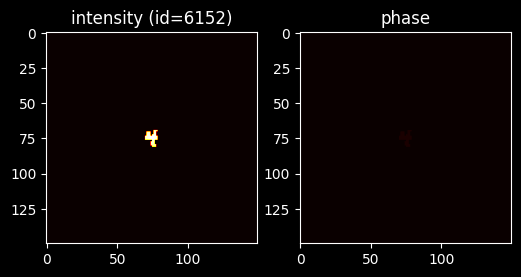

In [134]:
# plot an image
# '1' - 3214, good (1318, )
# '4' - 6152, good (1985, )
# '5' - (5134, )
# '6' - 123, good
# '8' - 128, good (1124, 8105)
# '0' - 3, good
ind_test = 6152
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity[0], cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase[0], cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [135]:
test_target

4

In [ ]:
# распространение примера через обученную систему
setup_scheme, test_wavefronts = optical_setup_loaded.stepwise_forward(test_wavefront)

#### Амплитудные профили

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Detector] -(17)->


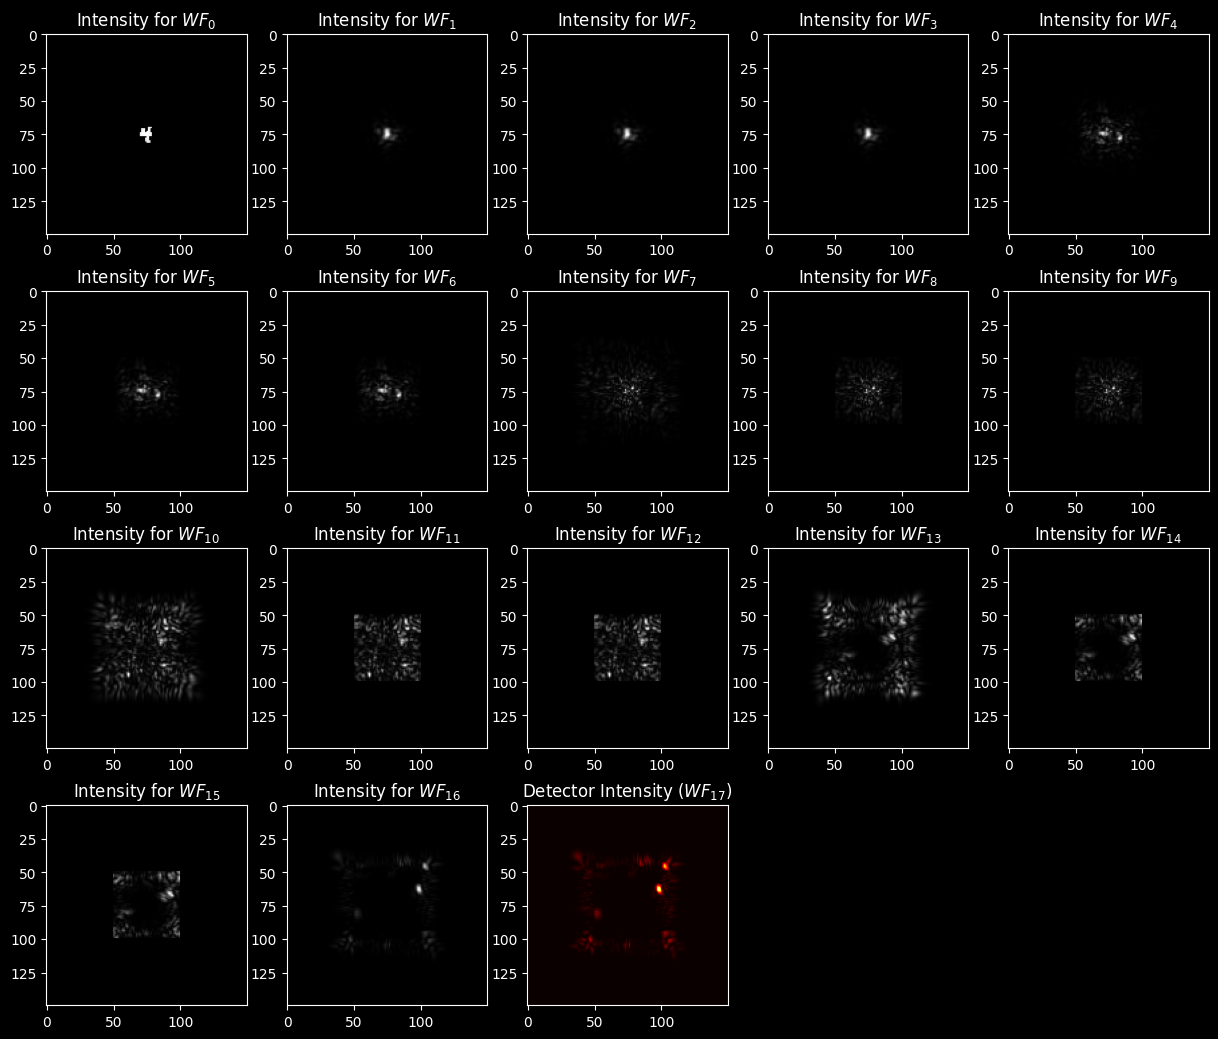

In [ ]:
print(setup_scheme)  # вывод системы

n_cols = 5  # количество колонок для визуализации волновых фронтов во время распространения
n_rows = (len(optical_setup_loaded.net) // n_cols) + 1

to_plot = 'amp'  # <--- выбор того, что будем отображать: 'amp' - амплитуду, 'phase' - фазу
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# создание фигуры с подграфиками
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# выключение лишних осей
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# строим волновые фронты
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # у детектора нет фазы!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # выход детектора (не wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )

    # Комментарий: выход детектора является тензором! У него нет методов  Wavefront (как .phase or .intensity)!

plt.show()

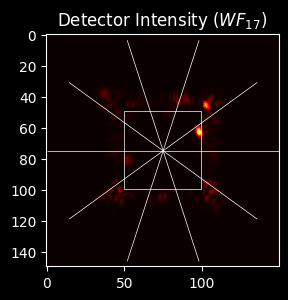

In [ ]:
# создаем фигуру с подграфиками
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# выход детектора (не wavefront!)
ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
ax_this.imshow(
    test_wavefronts[-1][0].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax_this.add_patch(zone)

plt.show()

#### Вероятности

In [ ]:
# получаем вероятности классов для последнего волнового фронта
test_probas = detector_processor.forward(test_wavefronts[-1])

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

0 : 0.85%
1 : 4.22%
2 : 5.14%
3 : 1.11%
4 : 64.29%
5 : 2.39%
6 : 1.11%
7 : 1.32%
8 : 0.70%
9 : 18.87%
